# Кластеризация
В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять,
в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов
к задаче уменьшения цветности изображения.

In [2]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [10]:
def visualize_clasters(X, labels, n_clusters=4):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(4, 4))
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
X_2, true_labels2 = make_moons(400, noise=0.075)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать — метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

Не забудте реинициализировать пустые кластеры!


In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random",
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.max_iter = max_iter
        self.init = init
        self.n_clusters = n_clusters

        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """



        if self.init == 'random':
            self.centroids_init = np.random.rand(self.n_clusters, len(X[0]))
            
        elif self.init == 'sample':
            self.centroids_init = random.choices(X, weights=None, cum_weights=None, k=self.n_clusters)
        
        elif self.init == 'k-means++':
            self.centroids_init = np.array(random.choices(X))


            for _ in range(self.n_clusters - 1):

                dist_to_closest = np.array([
                    np.min([np.linalg.norm(point - centroid) for centroid in self.centroids_init])
                                     for point in X])


                cumulative_prob = np.cumsum(dist_to_closest/np.sum(dist_to_closest))
                selected_index = next(index for index, val in enumerate(cumulative_prob)
                                                  if val > random.random())

                self.centroids_init = np.append(self.centroids_init, [X[selected_index]], axis=0)





        for _ in range(self.max_iter):

            closest_centers = np.array([np.argmin(
                [np.linalg.norm(point - center)
                        for center in self.centroids_init])
                                for point in X])

            self.centroids = [np.mean(
                    np.array([X[i] for i in range(len(X))
                              if closest_centers[i] == j]), axis=0)
                                                    for j in range(self.n_clusters)]
            self.centroids_init = self.centroids


    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера,
        к которому относится данный элемент.

        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.

        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров
            (по одному индексу для каждого элемента из X).

        """

        labels = [np.argmin(
            [np.linalg.norm(point - center)
                            for center in self.centroids])
                                    for point in X]
        return np.array(labels)

Протестируйте алгоритм на синтетических данных.
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

# Sample init

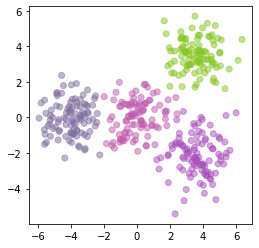

In [5]:
kmeans = KMeans(n_clusters=4, init = 'sample')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

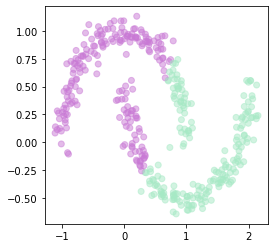

In [6]:
kmeans = KMeans(n_clusters=2, init = 'sample')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels, 2)

# Random init

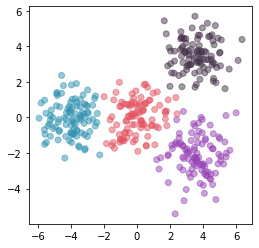

In [7]:
kmeans = KMeans(n_clusters=4, init = 'random')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

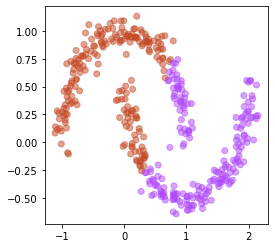

In [8]:
kmeans = KMeans(n_clusters=2, init = 'random')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels, 2)

# k-means++ init

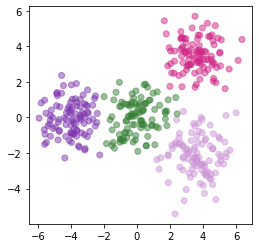

In [9]:
k_means = KMeans(n_clusters=4, init='k-means++')
k_means.fit(X_1)
labels = k_means.predict(X_1)
visualize_clasters(X_1, labels, 4)

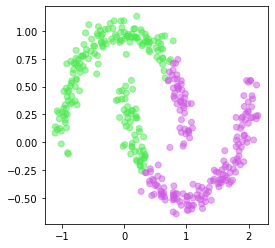

In [10]:
k_means = KMeans(n_clusters=4, init='k-means++')
k_means.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels, 2)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные.
Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [11]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "euclidean"):
        """

        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = 'euclidean'
        self.size = None


    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.size = len(X)
        neighbor = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        cls = [False for _ in range(self.size)]
        edges = {i: [] for i in range(self.size)}



        for i in range(self.size):
            neighbor_i = neighbor.query_radius(X[i:i+1], r=self.eps)
            if len(neighbor_i[0]) >= self.min_samples:
                cls[i] = True
                edges[i] = neighbor_i[0]



                for el in neighbor_i[0]:
                    cls[el] = True

        visited = set()
        labels = [-1] * self.size
        num_cl = -1

        for i in range(self.size):

            if cls[i] and i not in visited:

                num_cl += 1
                q = deque([i])

                while q:
                    s = q.popleft()
                    visited.add(s)
                    labels[s] = num_cl

                    for el in edges[s]:
                        if el not in visited:
                            visited.add(el)
                            q.append(el)
                            labels[el] = num_cl
        return labels

Протестируйте алгоритм на синтетических данных.
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

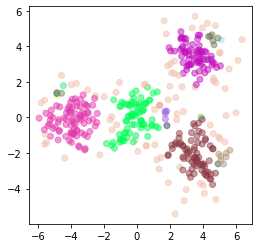

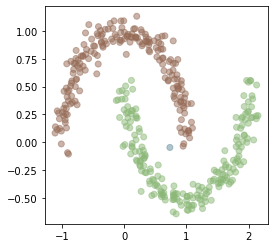

In [12]:
dbscan = DBScan(metric = "manhattan")
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между
ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим
только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами.
Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек,
где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек,
где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек,
где одна принадлежит первому кластеру, а другая - второму.

In [21]:
X_1, true_labels = make_blobs(100, 2, random_state = 42,  centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
X_2, _ = make_moons(100, noise=0.075)

In [4]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """

        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit_predict(self, X: np.array, y=None) -> np.array:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.size = len(X)
        eps = 1e8
        dist = np.zeros((self.size, self.size))

        for i in range(self.size):
            for j in range(self.size):
                dist[i, j] = np.linalg.norm(X[i] - X[j])
                dist[i, i] = eps

        labels = np.arange(self.size)
        curr_n_cluster = len(set(labels))

        while curr_n_cluster > self.n_clusters:
            i, j = np.unravel_index(np.argmin(dist), dist.shape)
            dist[i, j] = dist[j, i] = eps

            labels[labels == j] = labels[i]

            if self.linkage == "average":
                for el in labels:
                    if el != i:
                        dist[i, el] = dist[el, i] = dist[el, j] = dist[j, el] = np.mean([dist[i, el], dist[j, el]])

            elif self.linkage == "single":
                for el in labels:
                    if el != i:
                        dist[i, el] = dist[el, i] = dist[el, j] = dist[j, el] = min(dist[i, el], dist[j, el])

            elif self.linkage == "complete":
                for el in labels:
                    if el != i:
                        dist[i, el] = dist[el, i] = dist[el, j] = dist[j, el] = max(dist[i, el], dist[j, el])
            curr_n_cluster = len(set(labels))

        tmp = list(set(labels))
        for i in range(len(tmp)):
            labels[labels == tmp[i]] = i
        return labels

Протестируйте алгоритм на синтетических данных.
При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

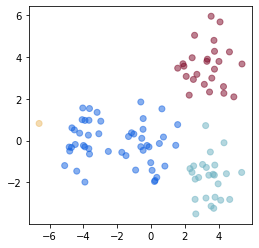

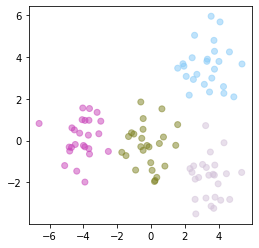

In [22]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="single")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)
visualize_clasters(X_1, true_labels)


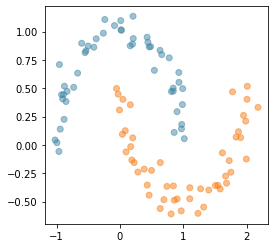

In [24]:
agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

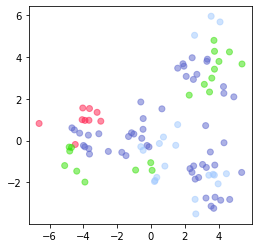

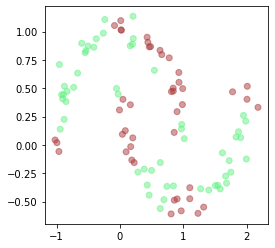

In [25]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="average")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

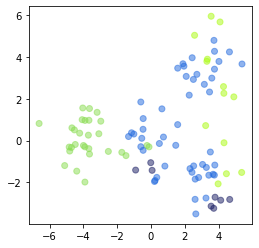

In [26]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)


In [27]:
agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="complete")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)


KeyboardInterrupt: 